# Fig 1: Halo model power spectra 
Power spectra for matter, galaxy and their cross-correlation using the standard halo model calculation. 

# Fig 2: Dimensionless multiplicity function $M^2 n(M)/\bar\rho$ and linear halo bias $b(M)$

This is a longer notebook and includes other plots, intended to teach how to use halomodel and associate modules. It also includes Figures 1 and 2 of the halo model review `(Asgari,Heymans and Mead 2022)`.

First we import the libraries we need:|

In [1]:
# Standard imports
import sys
import numpy as np
import matplotlib.pyplot as plt

# Third-party imports
import camb # Calculates the linear matter power spectrum

# Halo Model library imports
sys.path.append('../modules/')
import utility_functions as utility
import halomodel as halomodel

# Plotting settings
# Colours
col_lin = 'black'
col_mat = 'C0'
col_gal = 'C1'
col_cen = 'C3'
col_sat = 'C0'
col_mg  = 'C4'
col_cs  = 'C5'

# Line styles
ls_li = '-'
ls_hm = '-'
ls_2h = '--'
ls_1h = ':'

# Labels
klab = r'$k\,/\,h \mathrm{Mpc}^{-1}$'

Now we set the comsological parameters. If `sigma_8_set = True` we scale the linear power spectrum to account for the new sigma_8 value.  

In [2]:
# Set cosmological parameters
Omega_c = 0.25
Omega_b = 0.05
Omega_k = 0.0
h = 0.7
As = 1.97448e-9
ns = 0.96
w = -1.0
wa = 0.0
m_nu = 0.0 # in eV

# You can choose to set sigma_8, in that case we scale the power spectrum
sigma_8_set = True # if true uses the following value
sigma_8_in  = 0.7

Now let's set some parameters that we will use throughout the calculation: First, we set a range of wavenumbers, `k`, and then fill array, `ks`, we then set a redshift, `z`.

In [3]:
# k range [h/Mpc]
kmin = 1e-3; kmax = 200
nk = 101
ks = np.logspace(np.log10(kmin), np.log10(kmax), nk)

# Starting redshift
z = 0.
zmax = 2.

# Redshift
zs = [1., 0.] # CAMB reorders from high-z to low-z, so we define it like this from the start to avoid confusion

Now we initialise `CAMB` and produce a linear matter power spectrum. We have the option here to scale the power by an input `sigma_8` value: `sigma_8_in`

In [4]:
# Sets cosmological parameters in camb to calculate the linear power spectrum
pars = camb.CAMBparams()
wb   = Omega_b*h**2
wc   = Omega_c*h**2

# This function sets standard and helium set using BBN consistency
pars.set_cosmology(ombh2=wb, omch2=wc, H0=100.*h, mnu=m_nu, omk=Omega_k)
pars.set_dark_energy(w=w, wa=wa, dark_energy_model='ppf') 
pars.InitPower.set_params(As=As, ns=ns, r=0)
pars.set_matter_power(redshifts=zs, kmax=kmax) # Setup the linear matter power spectrum

# extract parameters from CAMB
Omega_m  = pars.omegam 
Omega_nu = pars.omeganu
Omega_L  = 1. + Omega_k - Omega_m
camb_results = camb.get_results(pars)
sigma_8 = (camb_results.get_sigma8()[zs.index(z)]).item()

if sigma_8_set:
#     sigma_8_original = sigma_8
    scaling = (sigma_8_in/sigma_8)**2
    As *= scaling
    pars.InitPower.set_params(As=As, ns=ns, r=0)
    

Pk_lin = camb.get_matter_power_interpolator(pars, 
                                            nonlinear = False, 
                                            hubble_units = True, 
                                            k_hunit = True, 
                                            kmax = kmax,
                                            var1 = camb.model.Transfer_tot,
                                            var2 = camb.model.Transfer_tot, 
                                            zmax = zmax,
                                           )
Pk_lin = Pk_lin.P # Single out the linear P(k) interpolator
camb_results = camb.get_results(pars)
sigma_8 = (camb_results.get_sigma8()[zs.index(z)]).item()
Omega_L

0.7

In [5]:
np.log(As*1e10)

2.715821534494695

Now we set a range of halo masses, `M`, and fill an array, `Ms`. This halo-mass range needs to be wide enough that it includes all 'interesting' halo masses from the point of view of the calculation, and the mass-spacing needs to be fine enough that the calculation converges; in an actual use-case the effect on power spectra of both mass range and spacing should be convergence tested. Then we find the Lagrangian radii, `R`, corresponding the the halo masses.

In [6]:
# # Halo mass range [Msun/h]
# Mmin = 1e8; Mmax = 1e16
# nM = 1025
# Ms = np.logspace(np.log10(Mmin), np.log10(Mmax), nM)

# To speed things we use these settings if you want more precision use the above numbers
# Halo mass range [Msun/h]
Mmin = 1e9; Mmax = 1e15; nM = 129
Ms = np.logspace(np.log10(Mmin), np.log10(Mmax), nM)

# Lagrangian radii corresponding to halo masses; 
Rs = utility.Radius_M(Ms, Omega_m)

Next, we need to get an array of `sigma(R)` values. This requires an integral over the linear power spectrum times the Fourier transform of a top hat function, which is the oscillatory sinc function. We can use different integration methods to calculate this. Three methods are given: 
* `brute`: uses a brute force sum over `nk` log-bins between `kmin` and `kmax`
* `quad`: uses the scipy.integrate.quad routine integrates between zero and infinity
* `camb`: uses the internal camb integration

In [7]:
# Get sigma(R) brute force
# sigmaRs_brute = utility.get_sigmaR(Rs,Pk_lin=lambda k: Pk_lin(0, k),kmin=1e-5,kmax=1e5,nk=1e5,integration_type='brute')

# Get sigma(R) using quad integration. Ignore the warning it is pretty accurate
# sigmaRs_quad = utility.get_sigmaR(Rs,Pk_lin=lambda k: Pk_lin(0, k),integration_type='quad')
# sigmaRs = sigmaRs_quad

sigmaRs_camb = utility.get_sigmaR(Rs,camb_results,integration_type='camb')
sigmaRs = sigmaRs_camb

Now we can create a halo model, which has to be reinitialised at each different redshift of interest. In this example notebook we are only doing calculations at a single redshift, so we initialise the halo model with that in mind. We also need to choose a mass function and linear halo bias, in this example these come from `Tinker et al. (2010)`, and we need to choose a halo definition, here we choose `330`, so haloes are defined to be spherical objects that contain an average density that is 330 times greater than the mean background universe, which is approximately the virial definition for this cosmology at `z=0`.

In [8]:
# Initialise halo model
hmod = halomodel.halomod(z, Omega_m, hm='Tinker et al. (2010)', Dv=330.)

# Calculate the matter density
rhom = utility.comoving_matter_density(Omega_m) 
print('Mean matter density [log10((Msun/h)/(Mpc/h)^-3)]:', np.log10(rhom))

Mean matter density [log10((Msun/h)/(Mpc/h)^-3)]: 10.920442613693927


First, we will use the halo model to compute the matter power spectrum, to do this we need to define a matter halo. We use the `haloprof` class, which contains the Fourier window function of the halo profile `W(M,k)` that is necessary for the power-spectrum calculation. This is a 2D array of the window function evaluated at `(ks, Ms)` values defined above, so if these change then the `haloprof` must be updated. We break the function $W(M,k)=N(M)U(M,k)/{\rm norm}$ where `W(M,k)` has dimensions of field multiplied by volume, `N(M)/norm` has dimension of field multiplied by volume and `U(M,k)` is dimensionless and should tend to unity as k tends to zero, because its real space counter part is normalised. 

In our case, we are going to compute the power spectrum of matter overdensity (density contrast: $\delta_{\rm m}=(\rho-\bar\rho)/\bar\rho$), which is dimensionless. We take `N(M)=M`, ${\rm norm}=\bar\rho$, such that `N(M)/norm` = $M/\bar\rho$ and has dimensions of volume. We could also have set $N(M)=M/\bar\rho$ and `norm=1` and would get the same results. The distinction between these two approaches is important for discrete tracers, but not otherwise.

We also need to set the optional `mass=True` in the halo profile, to let it know that our profile corresponds to a matter profile. This is important because the contribtion to the matter power of haloes below `Mmin`, set above, is important to the calculation (much of the mass in the Universe is in very low mass haloes), and this flag allows this to be taken into account in a consistent way.

In [9]:
# TODO: Need to make a template for this

# Halo profile
# The idea is that the user defines their own halo profile in real space
# The code then creats the Fourier transform of it and uses that to compute all the relevant quantities


# set up your own real space profile

# Example
# NFW profile
# def NFW(r,rho_s,r_s):
#     return rho_s/(r/r_s)/(1+r/rs)**2

In [10]:
# Halo density profiles or window functions
Uk = np.zeros((nM, nk))
for iM, M in enumerate(Ms):
#     halo concentration c
    c = halomodel.conc_Duffy(M, z, 'Mvir') # Specifiy 'Mvir' for Duffy c(M)
    rv = halomodel.virial_radius(M, hmod.Dv, Omega_m) # Take Dv from the halomodel to ensure consistency
    for ik, k in enumerate(ks):
        Uk[iM, ik] = halomodel.win_NFW(k, rv, c)
        
# Initialise profile class
matter_profile = halomodel.haloprof(ks, Ms, N=Ms, Uk=Uk, norm=rhom, mass=True)  # Need mass=True here

Now we are in a position to combine our halo model with our matter profile and do a calculation of the power spectrum. Note that profile must be provided as a list: `[matter_profile]` rather than `matter_profile`. The reason for this will become apparent soon. We use the result from the quad integration above, but note that whichever we use the impact on the power spectrum is very small (<0.1%). 

In [11]:
# Calculate the halo-model power spectrum
Pk_2h, Pk_1h, Pk_hm = halomodel.Pk_hm(hmod, Ms, ks, [matter_profile], lambda k: Pk_lin(z, k), sigmas=sigmaRs[-1])

Now let's do some plotting. Note carefully that the output arrays `Pk_2h`, `Pk_1h`, and `Pk_hm` are three dimensional, with `k` in the third dimension. In this first example the other two dimensions are length `1` because we have only provided one profile, the `matter_profile`. So to access the power spectrum we need `Pk_xx[0, 0, :]`.

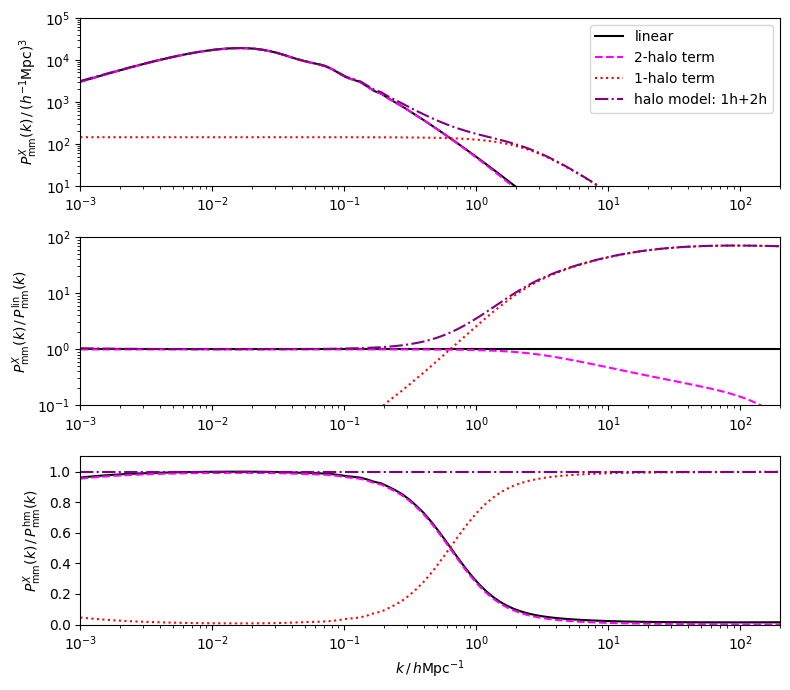

In [12]:
# Axis limits
Pkmin = 1e1; Pkmax = 1e5
rmin = 1e-1; rmax = 1e2
smin = 0.0; smax = 1.1

# Initialise plot
plt.subplots(3, 1, figsize=(8,7),dpi=100)

# P(k)
plt.subplot(3, 1, 1)
plt.loglog(ks, Pk_lin(z, ks), color=col_lin, label='linear')
plt.loglog(ks, Pk_2h[0, 0, :], color='magenta', ls='--', label='2-halo term')
plt.loglog(ks, Pk_1h[0, 0, :], color='red', ls=':', label='1-halo term')
plt.loglog(ks, Pk_hm[0, 0, :], color='purple', ls='-.', label='halo model: 1h+2h')
# plt.xticks([])
plt.xlim((kmin, kmax))
plt.ylabel(r'$P_\mathrm{mm}^{X}(k)\,/\,(h^{-1} \mathrm{Mpc})^3$')
plt.ylim((Pkmin, Pkmax))
plt.legend()

# Residual with linear
plt.subplot(3, 1, 2)
plt.loglog(ks, Pk_lin(z, ks)/Pk_lin(z, ks), color=col_lin)
plt.loglog(ks, Pk_2h[0, 0, :]/Pk_lin(z, ks), color='magenta', ls='--', label='2-halo term')
plt.loglog(ks, Pk_1h[0, 0, :]/Pk_lin(z, ks), color='red', ls=':', label='1-halo term')
plt.loglog(ks, Pk_hm[0, 0, :]/Pk_lin(z, ks), color='purple', ls='-.', label='halo model: 1h+2h')
# plt.xticks([])
plt.xlim((kmin, kmax))
plt.ylabel(r'$P_\mathrm{mm}^{X}(k)\,/\,P^\mathrm{lin}_{\rm mm}(k)$')
plt.ylim((rmin, rmax))

# Residual with halo-model matter power
plt.subplot(3, 1, 3)
plt.semilogx(ks, Pk_lin(z, ks)/Pk_hm[0, 0, :], color=col_lin, ls='-')
plt.semilogx(ks, Pk_2h[0, 0, :]/Pk_hm[0, 0, :], color='magenta', ls='--', label='2-halo term')
plt.semilogx(ks, Pk_1h[0, 0, :]/Pk_hm[0, 0, :], color='red', ls=':', label='1-halo term')
plt.semilogx(ks, Pk_hm[0, 0, :]/Pk_hm[0, 0, :], color='purple', ls='-.', label='halo model: 1h+2h')
plt.xlabel(klab)
plt.xlim((kmin, kmax))
plt.ylabel(r'$P_\mathrm{mm}^{X}(k)\,/\,P_\mathrm{mm}^\mathrm{hm}(k)$')
plt.ylim((smin, smax))

# Finish
plt.tight_layout()
plt.show()

The upper panel shows the halo-model matter power spectrum broken into 2- and 1-halo components, we see that the 2-halo term dominates at large scales while the 1-halo term dominates at small scales, as expected. We see that the 1-halo term has a constant 'shot-noise' contribution at large scales, and we see that the 2-halo term deviates from the linear spectrum only at small scales, and only where the 1-halo term is dominating the overall spectrum. The shot-noise contribution of the one-halo term at large scales is unphysical, and arises because neither mass nor momentum conservation have been imposed in the initial step of the derivation of the halo model, but this has very little impact in practice, although the one-halo term will eventually (and unphysically) dominate the power at ultra-large scales. The middle panel shows each spectra relative to linear and the bottom shows the contribution of the 2- and 1-halo terms to the total. Note that each term contributes equally at `k ~ 0.5 h/Mpc`, which is the transition region. The slight (and unphysical) deviation of the total power from the linear result can be seen at `k~10^-3 h/Mpc`.

Now let's calculate some galaxy spectra, first we need to specify a halo-occupation distribution (HOD) model to assign galaxies to haloes. In this example we choose a simple HOD, one that illustrates the basic point.

Mean galaxy density [(Mpc/h)^-3]: 0.005067374394369172


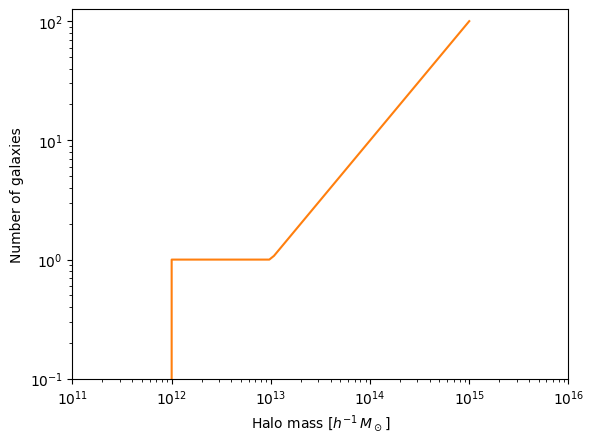

In [13]:
# Simple (unrealistic) HOD model
def HOD(M, Mmin=1e12, Msat=1e13):
    if M < Mmin:
        return 0.
    elif Mmin <= M and M < Msat:
        return 1.
    else:
        #return np.rint(M/Msat)
        return M/Msat

# Fill an array with galaxy number at each halo mass
Ng = np.zeros(nM)
for iM, M in enumerate(Ms):
    Ng[iM] = HOD(M)
    
# Compute the mean galaxy density corresponding to our HOD
rhog = halomodel.mean_hm(hmod, Ms, Ng, sigmas=sigmaRs[-1])
print('Mean galaxy density [(Mpc/h)^-3]:', rhog)

# Plot HOD
plt.loglog(Ms, Ng, color=col_gal)
plt.xlabel('Halo mass [$h^{-1}\,M_\odot$]')
plt.ylabel('Number of galaxies')
plt.ylim(bottom=1e-1)
plt.xlim((1e11, 1e16))
plt.show()

The unusual HOD has a step feature, but that is no problem for `halomodel`.

Now we can create a galaxy profile by combining the HOD with a halo window. Here we choose an isothermal profile `rho(r) ~ 1/r^2` for the galaxies and we set the `discrete=True` flag to let the calculation know that the halo profile corresponds to that of a discrete tracer, which ensures that `<N(N-1)>` is used in the one-halo term, rather than `<N^2>`. In the `W(M,k)=N(M)W(M,k)/norm` language we used before we have `N(M) = Ng(M)`, the number of galaxies in each halo, and `norm=rhog` the overall number-density of galaxies (dimension 1/volume). For discrete tracers (only) it is important to make the distinction between `N` and `norm`, and we would get different results if we set `N(M)=Ng(M)/norm` and `norm=1.`. We can then do a power spectrum calculation.

In [14]:
# Halo density profiles or window functions
Uk = np.zeros((nM, nk))
for iM, M in enumerate(Ms):
    c = halomodel.conc_Duffy(M, z, 'Mvir') # Specifiy 'Mvir' for Duffy c(M)
    rv = halomodel.virial_radius(M, hmod.Dv, Omega_m) # Take Dv from the halomodel to ensure consistency
    for ik, k in enumerate(ks):
        #Uk[iM, ik] = halomodel.win_isothermal(k, rv)
        Uk[iM, ik] = halomodel.win_NFW(k, rv, c)
        
# Initialise profile class
# Need discrete=True here because profile is of a discrete tracer
galaxy_profile = halomodel.haloprof(ks, Ms, N=Ng, Uk=Uk, norm=rhog, discrete=True)

# Calculate the halo-model power spectrum
Pk_2h_gg, Pk_1h_gg, Pk_hm_gg = halomodel.Pk_hm(hmod,Ms,ks,[galaxy_profile],lambda k: Pk_lin(z, k),sigmas=sigmaRs[-1])

And we can plot the results once more...

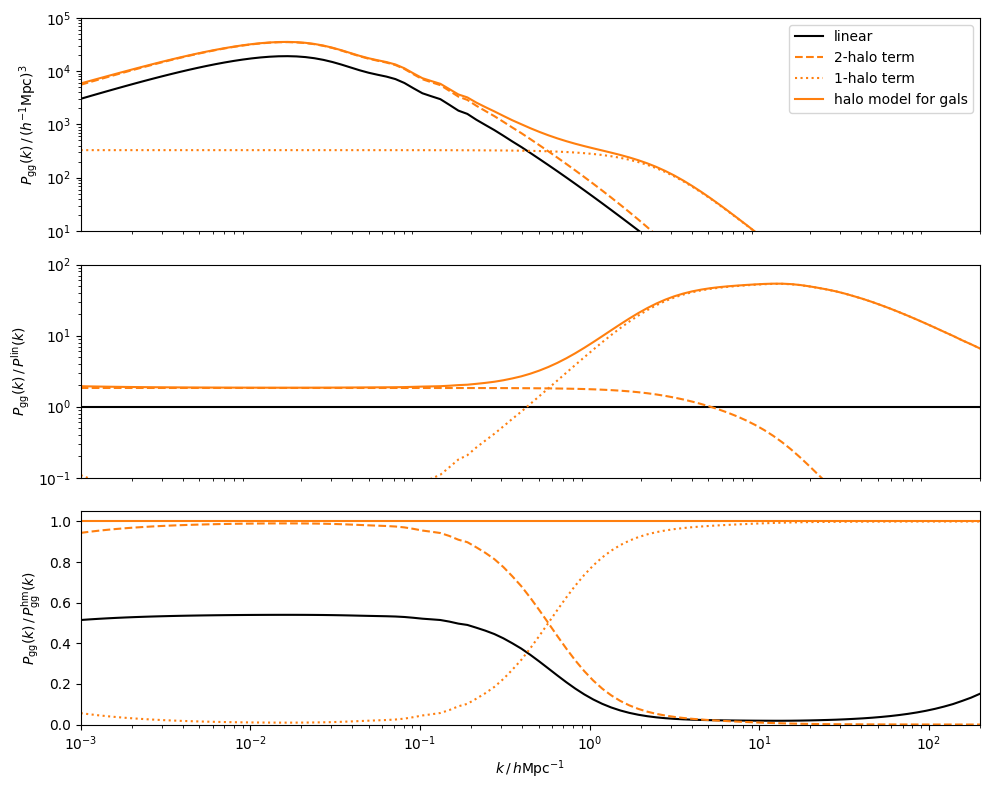

In [15]:
# Axis limits
Pkmin = 1e1; Pkmax = 1e5
rmin = 1e-1; rmax = 1e2
smin = 0.; smax = 1.05

# Initialise plot
plt.subplots(3, 1, figsize=(10,8))

# P(k)
plt.subplot(3, 1, 1)
plt.loglog(ks, Pk_lin(z, ks), color=col_lin, label='linear')
plt.loglog(ks, Pk_2h_gg[0, 0, :], color=col_gal, ls='--', label='2-halo term')
plt.loglog(ks, Pk_1h_gg[0, 0, :], color=col_gal, ls=':', label='1-halo term')
plt.loglog(ks, Pk_hm_gg[0, 0, :], color=col_gal, ls='-', label='halo model for gals')
plt.xticks([])
plt.xlim((kmin, kmax))
plt.ylabel(r'$P_\mathrm{gg}(k)\,/\,(h^{-1} \mathrm{Mpc})^3$')
plt.ylim((Pkmin, Pkmax))
plt.legend()

# Residual with linear
plt.subplot(3, 1, 2)
plt.loglog(ks, Pk_lin(z, ks)/Pk_lin(z, ks), color=col_lin)
plt.loglog(ks, Pk_2h_gg[0, 0, :]/Pk_lin(z, ks), color=col_gal, ls='--')
plt.loglog(ks, Pk_1h_gg[0, 0, :]/Pk_lin(z, ks), color=col_gal, ls=':')
plt.loglog(ks, Pk_hm_gg[0, 0, :]/Pk_lin(z, ks), color=col_gal, ls='-')
plt.xticks([])
plt.xlim((kmin, kmax))
plt.ylabel(r'$P_\mathrm{gg}(k)\,/\,P^\mathrm{lin}(k)$')
plt.ylim((rmin, rmax))

# Residual with halo-model matter power
plt.subplot(3, 1, 3)
plt.semilogx(ks, Pk_lin(z, ks)/Pk_hm_gg[0, 0, :], color=col_lin, ls='-')
plt.semilogx(ks, Pk_2h_gg[0, 0, :]/Pk_hm_gg[0, 0, :], color=col_gal, ls='--')
plt.semilogx(ks, Pk_1h_gg[0, 0, :]/Pk_hm_gg[0, 0, :], color=col_gal, ls=':')
plt.semilogx(ks, Pk_hm_gg[0, 0, :]/Pk_hm_gg[0, 0, :], color=col_gal, ls='-')
plt.xlabel(klab)
plt.xlim((kmin, kmax))
plt.ylabel(r'$P_\mathrm{gg}(k)\,/\,P_\mathrm{gg}^\mathrm{hm}(k)$')
plt.ylim((smin, smax))

# Finish
plt.tight_layout()
plt.show()

The galaxy spectrum looks superficially similar to the matter spectrum but the details are different. Note the large-scale bias means that the amplitude of the galaxy spectrum is elevated with respect to the linear spectrum. The relative amplitude of this offset is the squared bias of our galaxy sample, and so it looks like our HOD corresponds to a galaxy sample with `b ~ 1.3`. Note that in the case of the galaxy sample the large-scale shot noise in the one-halo term, as the galaxy distribution is not restrained by either mass or momentum conservation. However, in this example the classic `1/n` galaxy shot noise has been subtracted from the spectrum, which is already handled by the one-halo calculation. If one would rather retain this shot noise, then one can set the `shot=True` flag in the `halomodel.Pk_hm` calculation.

Now that we have created both matter and galaxy profiles, it is easy to cross correlate them by supplying a list of the two halo profiles. When we do this, the code calculates both auto spectra and also the cross spectrum. If we supply `n` halo profiles then we get the triangle number of `n` independent auto/cross spectra computed. These are stored in the first two dimensions of the `Pk_xx[:, :, :]` arrays, each of length `n`, so there is some redundancy.

In [16]:
# Calculate the halo-model power spectrum
profiles = [matter_profile, galaxy_profile]
Pk_2h, Pk_1h, Pk_hm = halomodel.Pk_hm(hmod, Ms, ks, profiles, lambda k: Pk_lin(z, k), sigmas=sigmaRs[-1])#, shot=True)

...and plot, noting that `Pk_xx[0, 0, :]` singles out the matter-matter (auto) spectrum, `Pk_xx[1, 1, :]` singles out the galaxy-galaxy (auto) spectrum, and `Pk_xx[0, 1, :]` singles out the matter-galaxy cross spectrum, and is identical to `Pk_xx[1, 0, :]`:

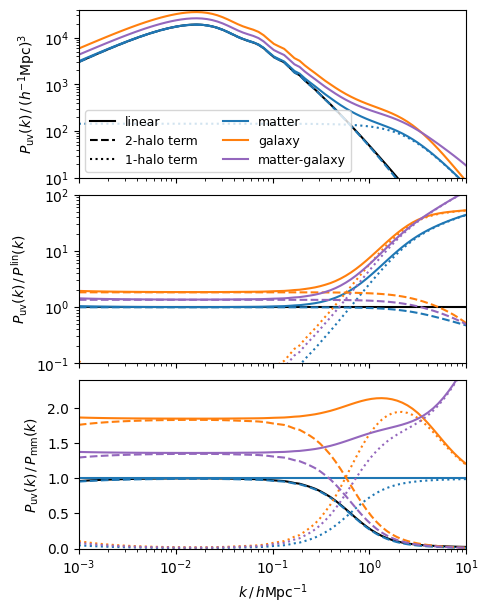

In [17]:
# Plot matter, galaxy and cross spectra

# Axis limits
Pkmin = 1e1; Pkmax = 4e4
kmin_plot = 1e-3; kmax_plot = 1e1
rmin = 1e-1; rmax = 1e2
smin = 0.; smax = 2.4

# Initialise plot
#fig=plt.figure(figsize=(8,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplots(3, 1, figsize=(5,7),dpi= 100, sharex=True)
plt.subplots_adjust(wspace=0.1,hspace=0.1) 

# Lists for plots
Pks = [Pk_2h[0, 0, :], Pk_1h[0, 0, :], Pk_hm[0, 0, :], Pk_hm[1, 1, :], Pk_hm[0, 1, :]]
cols = 3*[col_mat]+[col_gal, col_mg]
lss = ['--', ':', '-', '-', '-']
labs = [None, None, 'matter', 'galaxy', 'matter-galaxy']

# P(k)
plt.subplot(3, 1, 1)
plt.loglog(ks, Pk_lin(z, ks), color=col_lin, label='linear')
for (ls, lab) in zip(['--', ':'], ['2-halo term', '1-halo term']):
    plt.plot(np.nan, ls=ls, label=lab, color='black')

for (Pk, col, ls, lab) in zip(Pks, cols, lss, labs):
    plt.loglog(ks, Pk, color=col, ls=ls, label=lab)

plt.xticks([])
plt.xlim((kmin_plot, kmax_plot))
plt.ylabel(r'$P_{\rm uv}(k)\,/\,(h^{-1} \mathrm{Mpc})^3$')
plt.ylim((Pkmin, Pkmax))
plt.legend(ncol=2, loc='lower left',fontsize='9')

# Lists for plots
Pks = [Pk_2h[0, 0, :], Pk_1h[0, 0, :], Pk_hm[0, 0, :],
       Pk_2h[1, 1, :], Pk_1h[1, 1, :], Pk_hm[1, 1, :],
       Pk_2h[0, 1, :], Pk_1h[0, 1, :], Pk_hm[0, 1, :]]
cols = 3*[col_mat]+3*[col_gal]+3*[col_mg]
lss = 3*['--', ':', '-']

# Residual with linear
plt.subplot(3, 1, 2)
plt.loglog(ks, Pk_lin(z, ks)/Pk_lin(z, ks), color=col_lin)
for (Pk, col, ls) in zip(Pks, cols, lss):
    plt.loglog(ks, Pk/Pk_lin(z, ks), color=col, ls=ls)
plt.xticks([])
plt.xlim((kmin_plot, kmax_plot))
plt.ylabel(r'$P_{\rm uv}(k)\,/\,P^\mathrm{lin}(k)$')
plt.ylim((rmin, rmax))

# Residual with halo-model matter power
plt.subplot(3, 1, 3)
plt.semilogx(ks, Pk_lin(z, ks)/Pk_hm[0, 0, :], color=col_lin)
for (Pk, col, ls) in zip(Pks, cols, lss):
    plt.semilogx(ks, Pk/Pk_hm[0, 0, :], color=col, ls=ls)
plt.xlabel(klab)
plt.xlim((kmin_plot, kmax_plot))
plt.ylabel(r'$P_{\rm uv}(k)\,/\,P_\mathrm{mm}(k)$')
plt.ylim((smin, smax))

# Finish
#plt.tight_layout()
plt.savefig('plots/power_HOD_all.pdf',bbox_inches='tight')
plt.show()

This is Figure 1 of the review paper. 

We see that all spectra have the same shape at large scales, but that those spectra that involve galaxies are offset in amplitude. This tells us that the galaxy sample is positively biased, with `b~1.3`. At smaller scales the spectra are all similarly shaped, but the exact scale dependence is different for each. This arises because of the different way that matter and galaxies occupy haloes.

Now lets make figure 2: Dimensionless multiplicity function, $M^2 n(M)/\bar\rho$, as a function of halo mass for three popular halo mass functions: Sheth and Tormen 1999; Tinker et al. 2010; Despali et al. 2016 at z = 0 (solid) and z = 1 (dashed) for the virial halo definition. Note that the kmax value for Pk_lin is very important here. We chose kmax=200, which produces smooth functions. A smaller kmax can produce noisy results for lower masses.

In [18]:
mass_functions = [
    'Sheth & Tormen (1999)',
    'Tinker et al. (2010)',
    'Despali et al. (2016)',
]

# TODO: ALLOW certain parts of halomodel to be updated
# TODO: Check this code. Why is there a factor of 2?
# Calculate b(M) and n(M)
bs = []
Fs = []
for iz, z in enumerate(zs):
    for mass_function in mass_functions:
        print(mass_function, 'z = %1.1f'%(z))
        hmod = halomodel.halomod(z, Omega_m, hm=mass_function, Dv=330.)
        b = halomodel.linear_halo_bias(hmod, Ms, sigmas=sigmaRs[iz])
        F = halomodel.halo_multiplicity_function(hmod, Ms, Pk_lin=lambda k: Pk_lin(z, k))
        bs.append(b)
        Fs.append(F)

Sheth & Tormen (1999) z = 1.0


/Users/Mead/Physics/halomodel_review/notebooks/../modules/utility_functions.py:73: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  sigma_squared, _ = integrate.quad(sigma_integrand, kmin, kmax)
/Users/Mead/Physics/halomodel_review/notebooks/../modules/utility_functions.py:101: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  p

Tinker et al. (2010) z = 1.0
Despali et al. (2016) z = 1.0
Sheth & Tormen (1999) z = 0.0
Tinker et al. (2010) z = 0.0
Despali et al. (2016) z = 0.0


/var/folders/fr/c2m_v4ss6kjcbgzbqfr_z5fw0000gn/T/ipykernel_69956/1686017762.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 1, 1)


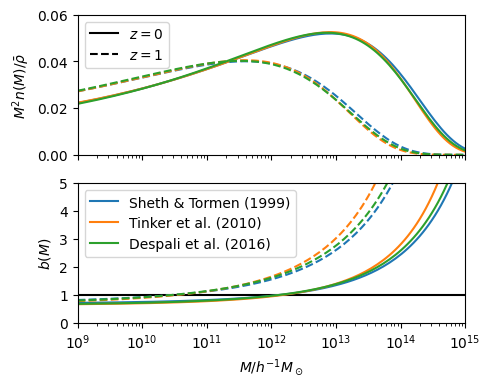

In [19]:
# Make the plot
plt.subplots(figsize=(5, 4), dpi=100, sharex=True)
n = len(mass_functions)

# Mass function
plt.subplot(2, 1, 1)
plt.plot(Ms[0], np.nan, color='black', ls='-', label=r'$z=0$')
plt.plot(Ms[0], np.nan, color='black', ls='--', label=r'$z=1$')
for i, mass_function in enumerate(mass_functions):
    plt.plot(Ms, Fs[i], ls='--', color='C%d'%i)
    plt.plot(Ms, Fs[i+n], ls='-', color='C%d'%i)
plt.xscale('log')
plt.gca().set_xticklabels([])
plt.ylim((0., 0.06))
plt.ylabel(r'$M^2 n(M)/\bar\rho$')
# Common x-axis
plt.xlim((Ms[0], Ms[-1]))
plt.legend()

# Linear bias
plt.subplot(2, 1, 2)
plt.axhline(1., color='black')
for i, mass_function in enumerate(mass_functions):
    plt.plot(Ms, bs[i], ls='--', color='C%d'%i)
    plt.plot(Ms, bs[i+n], ls='-', color='C%d'%i, label=mass_function)
plt.xlabel(r'$M / h^{-1} M_\odot$')
plt.xscale('log')
plt.ylim((0., 5.))
plt.ylabel(r'$b(M)$')

# Common x-axis
plt.xlim((Ms[0], Ms[-1]))
plt.legend()

plt.savefig('plots/hmf_and_bias.pdf',bbox_inches='tight')
plt.show()

The rest of the plots show how one can use the other functionalities of the halomodel code. Feel free to play around with this or move on to the other notebooks and see how the other figures in the review are created. 

Now, let's create a more realistic HOD with both central and satellite galaxies with their own unique statistical properties. We will use the Zheng et al. (2005) HOD model. In the more realistic example we also need to consider the variance both central and satellite occupation numbers at each halo mass. As is common, we will assume that central galaxies are Bernoulli distributed (either 0 or 1 with some probability) and that satellite galaxies are Poisson distributed.

Mean central galaxy density [(Mpc/h)^-3]: 0.004207326845275827
Mean satellite galaxy density [(Mpc/h)^-3]: 0.0017128518113288737
Mean galaxy density [(Mpc/h)^-3]: 0.0059201786566047
Central galaxy fraction: 0.7106756551311213
Satellite galaxy fraction: 0.28932434486887876


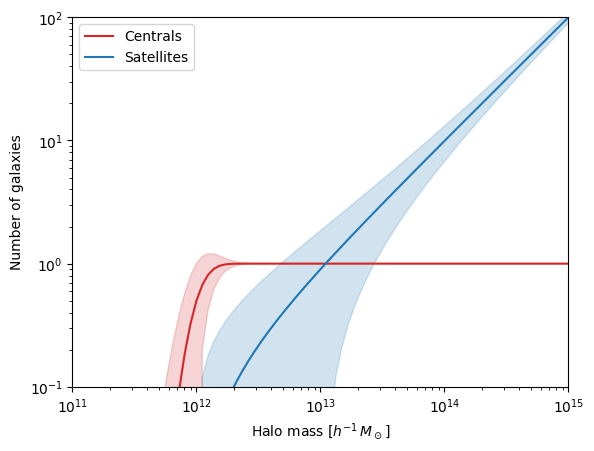

In [20]:
# Zheng et al. (2005) HOD with some reasonable parameters
def HOD_Zheng(M, Mmin=1e12, sigma=0.15, M0=1e12, M1=1e13, alpha=1.):
    from scipy.special import erf
    if sigma == 0.:
        Nc = np.heaviside(M-Mmin, 1.)
    else:
        Nc = 0.5*(1.+erf(np.log10(M/Mmin)/sigma))
    Ns = np.heaviside(M-M0, 1.)*((M-M0)/M1)**alpha
    return (Nc, Ns)

# Fill the numbers of central and satellite galaxies
N_cen, N_sat = HOD_Zheng(Ms)

# Calculate variance
V_cen = N_cen*(1.-N_cen) # Bernoulli statistics: mean = p; var = p(1-p)
V_sat = N_sat # Poisson statistics: mean = lam; var = lam

# Compute the mean galaxy density corresponding to our HOD
rho_cen = halomodel.mean_hm(hmod, Ms, N_cen, sigmas=sigmaRs[-1])
rho_sat = halomodel.mean_hm(hmod, Ms, N_sat, sigmas=sigmaRs[-1])
rho_gal = rho_cen+rho_sat
print('Mean central galaxy density [(Mpc/h)^-3]:', rho_cen)
print('Mean satellite galaxy density [(Mpc/h)^-3]:', rho_sat)
print('Mean galaxy density [(Mpc/h)^-3]:', rho_gal)
print('Central galaxy fraction:', rho_cen/rho_gal)
print('Satellite galaxy fraction:', rho_sat/rho_gal)

# Plot HOD
plt.fill_between(Ms, N_cen+np.sqrt(V_cen), N_cen-np.sqrt(V_cen), color=col_cen, alpha=0.2)
plt.fill_between(Ms, N_sat+np.sqrt(V_sat), N_sat-np.sqrt(V_sat), color=col_sat, alpha=0.2)
plt.loglog(Ms, N_cen, color=col_cen, label='Centrals')
plt.loglog(Ms, N_sat, color=col_sat, label='Satellites')
plt.xlabel('Halo mass [$h^{-1}\,M_\odot$]')
plt.xlim((1e11, 1e15))
plt.ylabel('Number of galaxies')
plt.ylim((1e-1, 1e2))
plt.legend()
plt.show()

On plotting the HOD distribution as a function of halo mass we can see the mean occupancy and its variance both look quite reasonable.

Now we can set up the profiles of the central and satellite galaxies and compute the halo model power. Here we include the variance via `var` optional argument; note that this corresponds to the variance in `N(M)` at each `M`. We then sum the component power spectra to get the total. We need to sum central-central, central-satellite, satellite-central and satellite-satellite. Note that central-satellite is equal to satellite-central, but both must be included (or twice one of them). Also note that we define `norm=rho_gal` for each halo profile, rather than `norm=rho_cen` or `norm=rho_sat`, which allows us to sum them nicely at the end. Here we have assumed that the presence of central and satellite galaxies are entirely independent, which allows for the possibility of haloes hosting a satellite galaxy without hosting a central. With the particular parameters we have chosen this is not important, but in general one may wish to impose the 'central-condition' that satellite galaxies cannot be present without a central. This introduces a covariance between central and satellite occupation that cannot be included in the current version of `pyhalomodel`.

In [21]:
z

0.0

In [22]:
# Halo density profiles or window functions
Uk_cen = np.zeros((nM, nk)); Uk_sat = np.zeros((nM, nk))
for iM, M in enumerate(Ms):
    c = halomodel.conc_Duffy(M, z, 'Mvir') # Specifiy 'Mvir' for Duffy c(M)
    rv = halomodel.virial_radius(M, hmod.Dv, Omega_m) # Take Dv from the halomodel to ensure consistency
    for ik, k in enumerate(ks):
        Uk_cen[iM, ik] = 1.
        Uk_sat[iM, ik] = halomodel.win_NFW(k, rv, c)

# Initialise profile class; need discrete=True here because profile is of a discrete tracer
central_profile = halomodel.haloprof(ks, Ms, N=N_cen, Uk=Uk_cen, norm=rho_gal, var=V_cen, discrete=True)
satellite_profile = halomodel.haloprof(ks, Ms, N=N_sat, Uk=Uk_sat, norm=rho_gal, var=V_sat, discrete=True)

# Calculate the halo-model power spectrum
profiles = [central_profile, satellite_profile]
_, _, Pk_hm = halomodel.Pk_hm(hmod, Ms, ks, profiles, lambda k: Pk_lin(z, k), sigmas=sigmaRs[-1])

# Sum to get the total galaxy power; cross terms are identical, but we need to include both in the sum
Pk_gg = Pk_hm[0, 0, :]+Pk_hm[0, 1, :]+Pk_hm[1, 0, :]+Pk_hm[1, 1, :]

... and plot the power spectra of centrals, satellites, their cross spectra and the total...

/var/folders/fr/c2m_v4ss6kjcbgzbqfr_z5fw0000gn/T/ipykernel_69956/3654546557.py:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, 1)
/var/folders/fr/c2m_v4ss6kjcbgzbqfr_z5fw0000gn/T/ipykernel_69956/3654546557.py:26: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, 2)


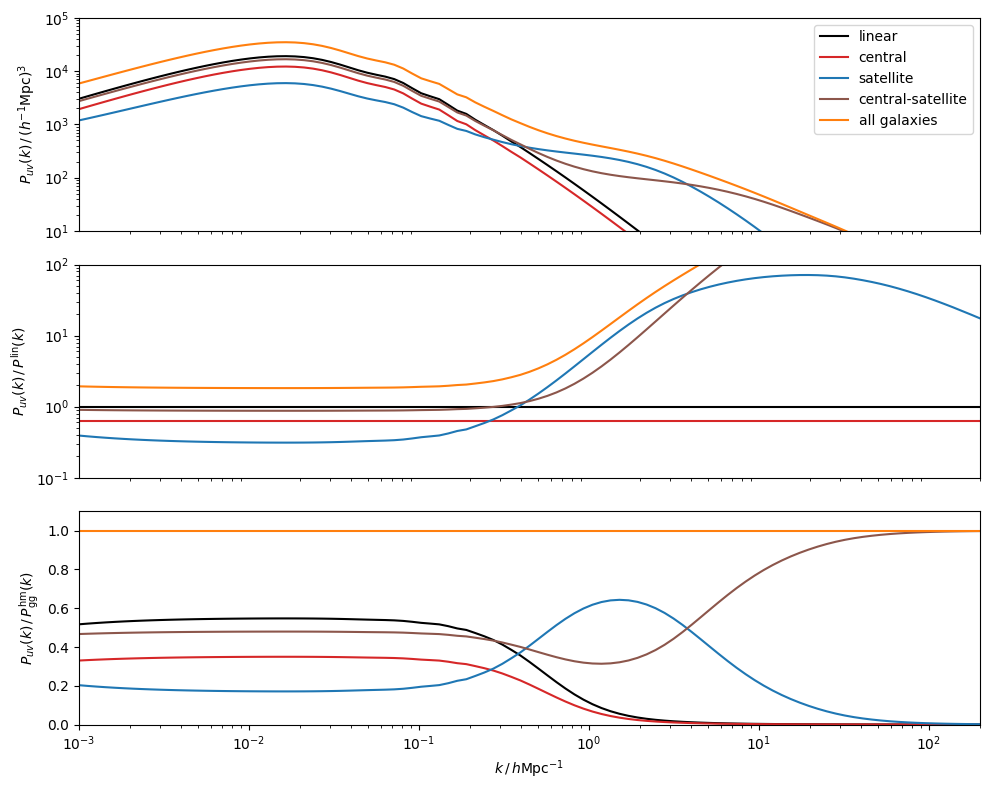

In [23]:
# Axis limits
Pkmin = 1e1; Pkmax = 1e5
rmin = 1e-1; rmax = 1e2
smin = 0.; smax = 1.1

# Initialise plot
plt.subplots(2, 1, figsize=(10,8))

# Lists for plot
Pks = [Pk_hm[0, 0, :], Pk_hm[1, 1, :], 2.*Pk_hm[0, 1, :], Pk_gg]
cols = [col_cen, col_sat, col_cs, col_gal]
labs = ['central', 'satellite', 'central-satellite', 'all galaxies']

# P(k)
plt.subplot(3, 1, 1)
plt.loglog(ks, Pk_lin(z, ks), color=col_lin, label='linear')
for (Pk, col, lab) in zip(Pks, cols, labs):
    plt.loglog(ks, Pk, color=col, label=lab)
plt.xticks([])
plt.xlim((kmin, kmax))
plt.ylabel(r'$P_{uv}(k)\,/\,(h^{-1} \mathrm{Mpc})^3$')
plt.ylim((Pkmin, Pkmax))
plt.legend()

# Residual with linear
plt.subplot(3, 1, 2)
plt.loglog(ks, Pk_lin(z, ks)/Pk_lin(z, ks), color=col_lin)
for (Pk, col) in zip(Pks, cols):
    plt.loglog(ks, Pk/Pk_lin(z, ks), color=col)
plt.xticks([])
plt.xlim((kmin, kmax))
plt.ylabel(r'$P_{uv}(k)\,/\,P^\mathrm{lin}(k)$')
plt.ylim((rmin, rmax))

# Residual with halo-model matter power
plt.subplot(3, 1, 3)
plt.semilogx(ks, Pk_lin(z, ks)/Pk_gg, color='black')
for (Pk, col) in zip(Pks, cols):
    plt.semilogx(ks, Pk/Pk_gg, color=col)
plt.xlabel(klab)
plt.xlim((kmin, kmax))
plt.ylabel(r'$P_{uv}(k)\,/\,P_\mathrm{gg}^\mathrm{hm}(k)$')
plt.ylim((smin, smax))

# Finish
plt.tight_layout()
plt.show()

We can see that the central-central, central-satellite, satellite-central and central-central terms all contribute roughly equally at large scales (which is a coincidence for this particular HOD choice with this cosmology and redshift; note that twice the central-satellite term is plotted), then the satellite auto spectrum dominates at intermediate scales, while the central-satellite cross spectrum dominates at the smallest scales.

Another (approximate) way of calculating the total galaxy spectrum is in 'one go', rather than by summing contributions. Here we generate a total galaxy HOD under the assumption that the total occupation variance is the sum of the variances of central and satellite:

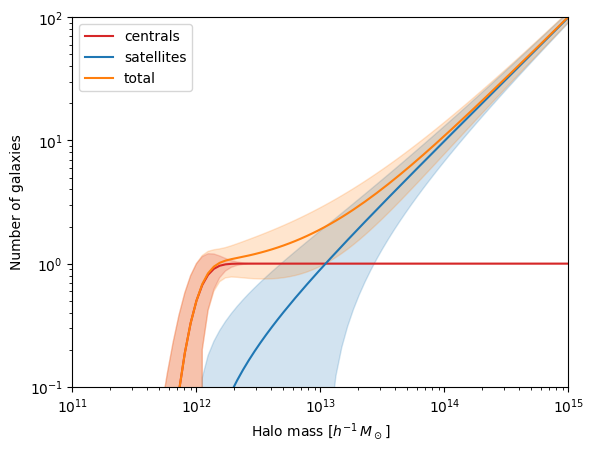

In [24]:
# Calculate the total number of galaxies and the variance of the total
N_gal = N_cen+N_sat # Total galaxies is a sum of central and satellites
V_gal = V_cen+V_sat # If galaxy distributions are independent then variances add

# Plot HOD
for (N, V, col) in zip([N_cen, N_sat, N_gal], [V_cen, V_sat, V_gal], [col_cen, col_sat, col_gal]):
    plt.fill_between(Ms, N+np.sqrt(V), N-np.sqrt(V), color=col, alpha=0.2)
for (N, col, lab) in zip([N_cen, N_sat, N_gal], [col_cen, col_sat, col_gal], ['centrals', 'satellites', 'total']):
    plt.loglog(Ms, N, color=col, label=lab)
plt.xlabel('Halo mass [$h^{-1}\,M_\odot$]')
plt.xlim((1e11, 1e15))
plt.ylabel('Number of galaxies')
plt.ylim((1e-1, 1e2))
plt.legend()
plt.show()

We see that the total mean number of galaxies and its variance both look reasonable.

Now we can compute the halo profile corresponding to the galaxies. This is a sum of the profiles for centrals and satellites, but weighted by the occupation number of each. With this in hand we can compute our halo model...

In [25]:
# Calculate a galaxy profile as a weighted-mean profile
Uk_gal = np.zeros((nM, nk))
for iM, _ in enumerate(Ms):
    if N_gal[iM] == 0.:
        Uk_gal[iM, :] = 0.
    else:
        # Weighted mean profile for the sum
        for ik, _ in enumerate(ks):
            Uk_gal[iM, ik] = (N_cen[iM]*Uk_cen[iM, ik]+N_sat[iM]*Uk_sat[iM, ik])/N_gal[iM]
            
# Halo profile
galaxy_profile = halomodel.haloprof(ks, Ms, N=N_gal, Uk=Uk_gal, norm=rho_gal, var=V_gal, discrete=True)

# Power calculation
_, _, Pk_hm = halomodel.Pk_hm(hmod, Ms, ks, [galaxy_profile], lambda k: Pk_lin(z, k), sigmas=sigmaRs[-1])
P_sn = 1./rho_gal

... and plot a comparison of the power spectra of the approximate model to the correct model ...

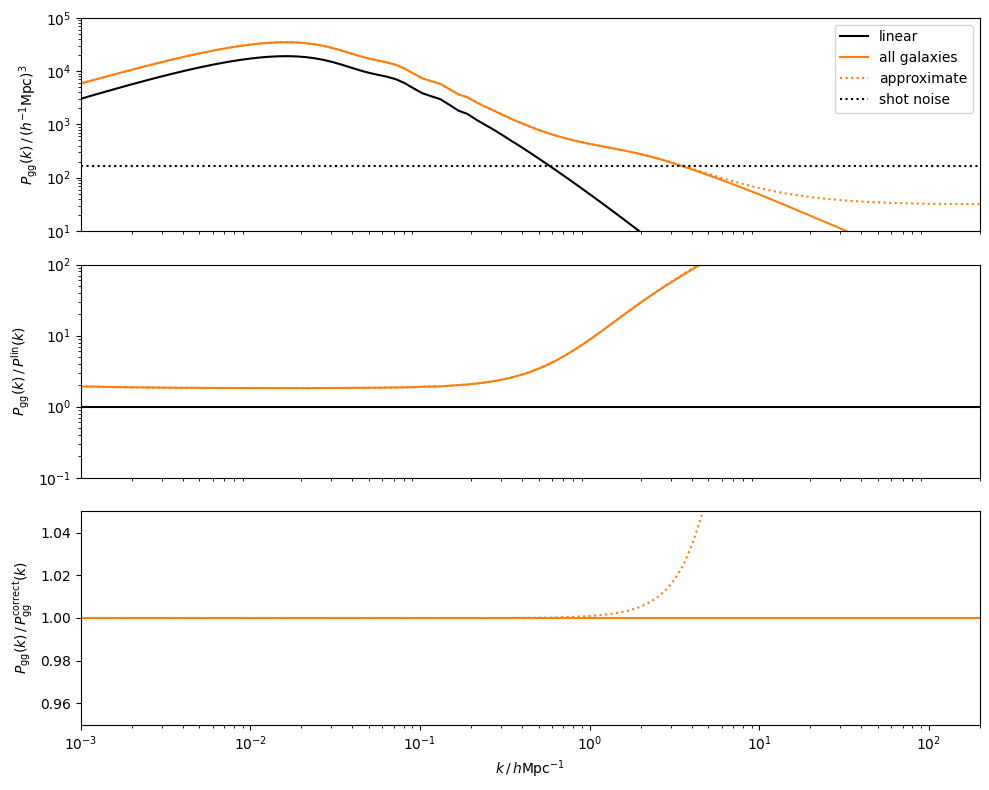

In [26]:
# Axis limits
Pkmin = 1e1; Pkmax = 1e5
rmin = 1e-1; rmax = 1e2
smin = 0.95; smax = 1.05

# Initialise plot
plt.subplots(3, 1, figsize=(10,8))

# P(k)
plt.subplot(3, 1, 1)
plt.loglog(ks, Pk_lin(z, ks), color=col_lin, label='linear')
plt.loglog(ks, Pk_gg, color=col_gal, label='all galaxies')
plt.loglog(ks, Pk_hm[0, 0, :], color=col_gal, ls=':', label='approximate')
plt.loglog(ks, len(ks)*[P_sn], color='black', ls=':', label='shot noise')
plt.xticks([])
plt.xlim((kmin, kmax))
plt.ylabel(r'$P_\mathrm{gg}(k)\,/\,(h^{-1} \mathrm{Mpc})^3$')
plt.ylim((Pkmin, Pkmax))
plt.legend()

# Residual with linear
plt.subplot(3, 1, 2)
plt.loglog(ks, Pk_lin(z, ks)/Pk_lin(z, ks), color=col_lin)
plt.loglog(ks, Pk_gg/Pk_lin(z, ks), color=col_gal)
plt.loglog(ks, Pk_hm[0, 0, :]/Pk_lin(z, ks), ls=':', color=col_gal)
plt.xticks([])
plt.xlim((kmin, kmax))
plt.ylabel(r'$P_\mathrm{gg}(k)\,/\,P^\mathrm{lin}(k)$')
plt.ylim((rmin, rmax))

# Residual with halo-model matter power
plt.subplot(3, 1, 3)
plt.semilogx(ks, Pk_lin(z, ks)/Pk_gg, color=col_lin)
plt.semilogx(ks, Pk_gg/Pk_gg, color=col_gal)
plt.semilogx(ks, Pk_hm[0, 0, :]/Pk_gg, ls=':', color=col_gal)
plt.xlabel(klab)
plt.xlim((kmin, kmax))
plt.ylabel(r'$P_\mathrm{gg}(k)\,/\,P_\mathrm{gg}^\mathrm{correct}(k)$')
plt.ylim((smin, smax))

# Finish
plt.tight_layout()
plt.show()

We see that the approximate scheme agrees well with the full calculation, where central and satellite contributions are considered separately, but that we get ~1% deviations by k ~ 3 h/Mpc. In both cases shot noise (1/ng) has been subtracted from the galaxy power. The difference arises because in the correct central-central power, the one-halo term is automatically zero when shot-noise is subtracted (<N(N-1)> = 0 for central galaxies), however, in the approximate case the auto correlationo of the central galaxy profile always contributes to the one-halo term, even though its contribution is supressed by the larger contribution of the satellite profile. Since the central-galaxy profile is a delta function, it is spread evenly over all k in Fourier space, and it eventually (and incorrectly) dominates over the satellite contribution at some large wavenumber. There is no way of avoiding this unless the galaxy contribution is correctly split into central and satellites, eacch with their own statistical properies. The exact wavenumber where this error appears, and the effect it may have on the power, will be dependent on the HOD. We recommend always treating central and satellite galaxies separately.

Next, let's see what happens when we change the halo mass function used in the calculation. To do this, we will need to create some new 'halo models':

In [27]:
# Initialise halo models; all using virial halo definition
hms = ['Tinker et al. (2010)', 'Sheth & Tormen (1999)', 'Despali et al. (2016)']
hmods = []
for hm in hms:
    hmods.append(halomodel.halomod(z,Omega_m, hm=hm, Dv=330.))

# Use both matter and galaxy profiles
profiles = [matter_profile, galaxy_profile]

# Halo model computations
Pks = []
for hmod in hmods:
    _, _, Pk_hm = halomodel.Pk_hm(hmod, Ms, ks, profiles, lambda k: Pk_lin(z, k), sigmas=sigmaRs[-1])
    Pks.append(Pk_hm)

Then we can plot comparisons of the power spectra that have been computed using the different halo mass functions.

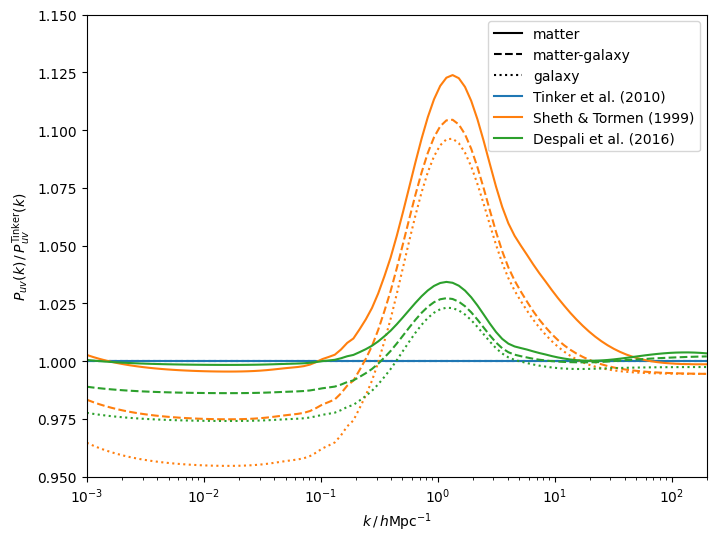

In [28]:
# Axis ranges
rmin = 0.95; rmax = 1.15

# P(k)
plt.figure(figsize=(8, 6))
for (ls, lab) in zip(['-', '--', ':'], ['matter', 'matter-galaxy', 'galaxy']):
    plt.plot(np.nan, color='black', ls=ls, label=lab)
for (col, Pk, hm) in zip(['C0', 'C1', 'C2'], Pks, hms):
    plt.semilogx(ks, Pk[0, 0, :]/Pks[0][0, 0, :], color=col, ls='-', label=hm)
    plt.semilogx(ks, Pk[0, 1, :]/Pks[0][0, 1, :], color=col, ls='--')
    plt.semilogx(ks, Pk[1, 1, :]/Pks[0][1, 1, :], color=col, ls=':')
plt.xlabel(klab)
plt.xlim((kmin, kmax))
plt.ylabel(r'$P_{uv}(k)\,/\,P^\mathrm{Tinker}_{uv}(k)$')
plt.ylim((rmin, rmax))
plt.legend()
plt.show()

We see that the choice of mass function can have O(10%) level effects on the power spectrum, with the effect being most pronouced around k = 1 h/Mpc. Sheth & Tormen (1999) predicts more high-mass haloes compared to the other mass functions, which results in a boost in power in intermediate regions and also a larger shot-noise contribution in the matter at large scales because the density field is decomposed into fewer haloes.

Finally, let's have a look at the matter power spectrum when we change the halo definition, but keep everything all as constant as possible.

In [29]:
# Create a new halo model for each new halo model
Dvs = [('M200', 200.), ('Mvir', 330.), ('M200c', 200./Omega_m)]
hmods = []
for (_, Dv) in Dvs:
    hmods.append(halomodel.halomod(z, Omega_m, hm='Tinker et al. (2010)', Dv=Dv, verbose=True)) 
    
# Halo density profiles or window functions
Uks = []
for (Mdef, Dv) in Dvs:
    Uk = np.zeros((nM, nk))
    for iM, M in enumerate(Ms):
        c = halomodel.conc_Duffy(M, z, Mdef) # Must use an appropriate concentration-mass relation 
        rv = halomodel.virial_radius(M, Dv, Omega_m) # Take Dv from the halomodel to ensure consistency
        for ik, k in enumerate(ks):
            Uk[iM, ik] = halomodel.win_NFW(k, rv, c)
    Uks.append(Uk)

# Create a separate matter profile for each halo definition
profiles = []
for Uk in Uks:
    profiles.append(halomodel.haloprof(ks, Ms, N=Ms, Uk=Uk, norm=rhom, mass=True))

Pks = []
for (hmod, profile) in zip(hmods, profiles):
    _, _, Pk_hm = halomodel.Pk_hm(hmod, Ms, ks, [profile], lambda k: Pk_lin(z, k), sigmas=sigmaRs[-1])
    Pks.append(Pk_hm)

Initialising halo model
scale factor: 1.000
redshift: 0.000
Omega_m(z=0): 0.300
delta_c: 1.6860
Delta_v: 200.0
Tinker et al. (2010) mass function
alpha: 0.368; beta: 0.589; gamma: 0.864; phi: -0.729; eta: -0.243
A: 1.000; a: 0.132
B: 0.183; b: 1.500
C: 0.265; c: 2.400

Initialising halo model
scale factor: 1.000
redshift: 0.000
Omega_m(z=0): 0.300
delta_c: 1.6860
Delta_v: 330.0
Tinker et al. (2010) mass function
alpha: 0.370; beta: 0.571; gamma: 0.944; phi: -0.829; eta: -0.261
A: 1.001; a: 0.228
B: 0.183; b: 1.500
C: 0.289; c: 2.400

Initialising halo model
scale factor: 1.000
redshift: 0.000
Omega_m(z=0): 0.300
delta_c: 1.6860
Delta_v: 666.7
Tinker et al. (2010) mass function
alpha: 0.390; beta: 0.551; gamma: 1.130; phi: -1.105; eta: -0.275
A: 1.012; a: 0.363
B: 0.183; b: 1.500
C: 0.325; c: 2.400



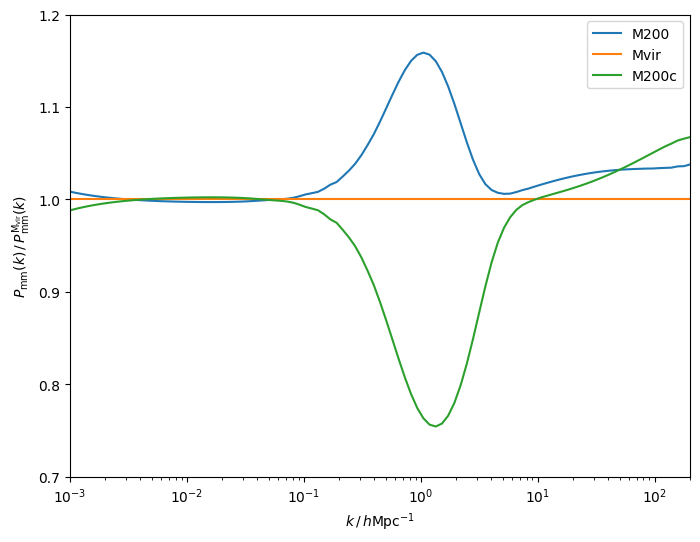

In [30]:
# P(k)
rmin = 0.70; rmax = 1.20 

# Loop over Dv definitions and plot
plt.figure(figsize=(8, 6))
for (col, Dv, Pk) in zip(['C0', 'C1', 'C2'], Dvs, Pks):
    plt.semilogx(ks, Pk[0, 0, :]/Pks[1][0, 0, :], color=col, ls='-', label=Dv[0])
plt.xlabel(klab)
plt.xlim((kmin, kmax))
plt.ylabel(r'$P_\mathrm{mm}(k)\,/\,P^\mathrm{M_{vir}}_\mathrm{mm}(k)$')
plt.ylim((rmin, rmax))
plt.legend()
plt.show()

Changing the halo-mass definition makes a surprisingly large difference to the overall power spectrum, particularly around the transition region. Clearly the matter power spectrum shoulnd not depend on how haloes are defined, so this final plot serves as a warning that one needs to be very careful with the halo model. Keep its level of accuracy in mind when using it for cosmological calculations! One needs to pick ingredients consistently and carefully, and also be aware of what is being missed in the standard calculation.